In [2]:
import numpy as np
from tqdm import tqdm
import networkx as nx
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
#!pip install torch_geometric
import torch_geometric
from typing import List
from IPython.display import clear_output
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import torch_geometric.transforms as T
sns.set_theme()
clear_output()

In [3]:
class Pool(nn.Module):

    def __init__(self,
                 k : List[int],
                 in_dim : float,
                 p : float):
        super(Pool, self).__init__()
        self.k = k # 0 to 1
        self.proj = nn.Linear(in_dim, 1) # Projection operator that gives scores with help of sigmoid
        self.sigmoid = nn.Sigmoid()

        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()

    def forward(self,
                adj_t : torch.Tensor,
                x : torch.Tensor):
        #Z = self.drop(g.x)

        # g.x is the tensor of shape (#nodes X features)
        projections = self.proj(x).squeeze() # output shape after projection is (#nodes, 1) ->  (#nodes) after squeeze
        scores = self.sigmoid(projections)
        return self.top_k_graph(scores, adj_t, x, self.k)

    def top_k_graph(self,
                    scores : torch.Tensor,
                    adj_t : torch.Tensor,
                    x : torch.Tensor,
                    k : int):
        '''
        Function to retrieve only some most important nodes
        scores - the tensor with scores for every node in given graph.
        graph - graph.....
        h - features of the graph
        k - how many to choose. Value from 0 to 1
        Returns features, adjacency matrix of the new graph, and the indices of vertices been selected
        '''

        x = self.drop(x)
        # Take k*100 % highest scores and their indices
        values, idx = torch.topk(scores, max(2, int(k*x.shape[0])))

        # Take features of nodes with best scores above
        new_h = x[idx, :] # Features for selected nodes. Shape is (k, feat_dim)

        values = torch.unsqueeze(values, -1) # Now dimension is (k, 1)

        # Here we have multiplication of matrix and column vector. In numpy it means we multiply every column of matrix by given column vector
        new_h = torch.mul(new_h, values) # obtain new unnormalized features after pooling. Shape is (k, feat_dim)


        # Create new adjacency matrix using indices.
        adj_t = adj_t.to_dense()
        adj_t = adj_t[idx, :]
        adj_t = adj_t[:, idx]
        adj_t = adj_t.bool().float()
        # Replace adjacency matrix by its second power to increase connectivity as stated in the paper
        adj_t = torch.matmul(adj_t, adj_t).bool().float()

        #degrees = torch.sum(adj_t, 1).unsqueeze(-1)
        #new_h = new_h / degrees # remember about self loops so no zero in denominator always

        adj_t = adj_t.to_sparse()
        x = new_h

        return x, adj_t, idx  # Return graph and indices we have taken from the INITIAL graph

In [4]:
class Unpool(nn.Module):

    def __init__(self):
        super(Unpool, self).__init__()

    def forward(self,
                adj_t : torch.Tensor,
                x : torch.Tensor,
                idx : torch.Tensor):
        new_x = x.new_zeros([adj_t.shape[0], x.shape[1]]) # Zero matrix
        new_x[idx] = x # Fill some row by features when specified
        return adj_t, new_x

In [5]:
class GraphUnet(nn.Module):
    '''
    This is the module that creates embeddings for nodes in given graph.
    So classifiers after this one are needed
    '''
    def __init__(self,
                 ks : List[int],
                 dim : int,
                 drop_p : float):
        '''
        ks - Values of k for pool layers
        dim - Dimensionality of input and output vectors in convolutions
        drop_p - probability for Dropout layer
        '''
        super(GraphUnet, self).__init__()
        self.ks = ks # Values of k for pool layers

        # Improved gives two selfloops instead of 1
        self.bottom_gcn = GCNConv(dim, dim, improved = True) # GCN at the bottom of the model picture in paper, that is medium from encoding to decoding
        self.down_gcns = nn.ModuleList() # GCNs before pooling
        self.up_gcns = nn.ModuleList() # GCN after unpooling
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()

        self.l_n = len(ks) # number of blocks GCN + pool AND corresponding unpool + GCN

        for i in range(self.l_n): # here we add blocks
            self.down_gcns.append(GCNConv(dim, dim, improved = True))
            self.up_gcns.append(GCNConv(dim, dim, improved = True))
            self.pools.append(Pool(ks[i], dim, drop_p))
            self.unpools.append(Unpool())

    def forward(self,
                g : torch.Tensor,
                h : torch.Tensor):
        adj_ms = [] # saved adjacencies
        indices_list = [] # saved indices lists from pooling for unpooling
        down_outs = [] # saved features
        hs = [] # all features after unpoolings and initial one
        org_h = h # initial features

        for i in range(self.l_n): # iterating over pooling blocks
            h = self.down_gcns[i](h, g) # GCN, obtain new features
            h = F.elu(h) # activation function
            adj_ms.append(g) # save adjacency matrix for unpooling layers
            down_outs.append(h) # save features for skip connections

            h, g, idx = self.pools[i](g, h) # Pooling
            indices_list.append(idx)  # save for unpooling layers
        h = self.bottom_gcn(h, g) # GCN at the bottom

        for i in range(self.l_n): # iterating over unpooling blocks
            up_idx = self.l_n - i - 1
            g, idx = adj_ms[up_idx], indices_list[up_idx]
            g, h = self.unpools[i](g, h, idx) # unpool with corresponding information from pooling
            h = self.up_gcns[i](h, g)
            h = F.elu(h)
            h = h.add(down_outs[up_idx]) # skip connection
            hs.append(h)
        h = h.add(org_h)
        hs.append(h)
        return hs

In [6]:
class Net(nn.Module):
    def __init__(self,
                 in_dim : int,
                 n_classes : int,
                 ks : List[int],
                 l_dim : int,
                 h_dim : int,
                 p_linear : float):
        '''
        in_dim - dimension of node embeddings in the input graph
        n_classes - number of classes to predict
        ks - rate for max-poolings.
        l_dim - dimension of nodes in U-NET, during convolutions
        h_dim - hidden dimension for linear layers
        p_linear - probability of dropout between linear layers
        '''
        super(Net, self).__init__()

        # Graph convolution to increase the dimensionality of nodes embeddings
        self.s_gcn = GCNConv(in_dim, l_dim, improved = True)
        # U-Net to obtain better embeddings
        self.g_unet = GraphUnet(
            ks, l_dim, 0.3)

        # Linear layers to make a classification on graph

        self.out_l_1 = nn.Linear(3*l_dim*(len(ks)+1), h_dim) # look at readout  function to see why we use such input dimension
        self.elu = torch.nn.ELU()
        self.out_drop = nn.Dropout(p=p_linear)
        self.out_l_2 = nn.Linear(h_dim, n_classes)
        #Initializer.weights_init(self)

    def forward(self, gs : List):
        # gs are the graphs
        hs = self.embed(gs) # make an embeddings for input graphs.
        logits = self.classify(hs) # make a predictions according to graph embeddings
        labels = torch.zeros(len(gs), dtype = torch.int64)
        for i, g in enumerate(gs):
          target = g.y[0]
          labels[i] = target
        return self.metric(logits, labels) # return loss and metric. loss will be used for backprop

    def embed(self, gs):
        '''
        Create embedding for all graphs in the input
        gs - graphs!!

        Returns embedding representations of every graph
        '''
        o_hs = []
        for g in gs:
            h = self.embed_one(g.adj_t, g.x)
            o_hs.append(h)
        hs = torch.stack(o_hs, 0) # to make a batch. dimension is (N_graphs, output_dim)
        return hs

    def embed_one(self, adj_t, h):
        '''
        Creates an embedding for the input graph

        g - adjacency matrix
        h - features of nodes

        Outputs embedding of the graph
        '''
        # degrees = torch.sum(adj_t, 1).unsqueeze(-1)
        # adj_t = adj_t.to_sparse()
        # new_h = new_h / degrees

        h = self.s_gcn(h, adj_t)
        h = F.elu(h)
        hs = self.g_unet(adj_t, h)
        h = self.readout(hs)
        return h

    def readout(self, hs : torch.tensor) -> torch.Tensor:
        '''
        Function to create embedding for the whole graph after u-net
        hs - Features of nodes
        Returns the embedding of the graph
        '''
        h_max = [torch.max(h, 0)[0] for h in hs]
        h_sum = [torch.sum(h, 0) for h in hs]
        h_mean = [torch.mean(h, 0) for h in hs]
        h = torch.cat(h_max + h_sum + h_mean)
        return h

    def classify(self, h):
        h = self.out_drop(h)
        h = self.out_l_1(h)
        h = self.elu(h)
        h = self.out_drop(h)
        h = self.out_l_2(h)
        return F.log_softmax(h, dim=1)

    def metric(self, logits, labels):
        loss = F.nll_loss(logits, labels)
        _, preds = torch.max(logits, 1)
        acc = torch.mean((preds == labels).float())
        return loss, acc

In [13]:
def run_epoch(epoch : int,
              loader,
              model,
              optimizer):
        '''
        data is the list of batches, every batch is the list of graphs
        '''
        losses, accs, n_samples = [], [], 0

        for batch in tqdm(loader, desc=str(epoch), unit='b'):
            #gs, hs, ys = map(self.to_cuda, [gs, hs, ys])
            cur_len = len(batch)

            loss, acc = model(batch)
            losses.append(loss*cur_len)
            accs.append(acc*cur_len)

            n_samples += cur_len

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        avg_loss, avg_acc = sum(losses) / n_samples, sum(accs) / n_samples
        return avg_loss.item(), avg_acc.item()

def train(optimizer, net, num_epochs, train_loader, test_loader):
        max_acc = 0.0
        train_str = 'Train epoch %d: loss %.5f acc %.5f'
        test_str = 'Test epoch %d: loss %.5f max %.5f'
        line_str = '%d:\t%.5f\n'

        train_losses = []
        test_losses = []
        for e_id in range(num_epochs):
            # TRAIN
            net.train()
            loss, acc = run_epoch(
                e_id, train_loader, net, optimizer)

            print(train_str % (e_id, loss, acc))
            train_losses.append(loss)
            # EVALUATE
            with torch.no_grad():
                net.eval()
                loss, acc = run_epoch(e_id, test_loader, net, None)
                test_losses.append(loss)
            max_acc = max(max_acc, acc)
            print(test_str % (e_id, loss, max_acc))
        return train_losses, test_losses

In [14]:
net = Net(in_dim = 3,
          n_classes = 2,
          ks = [0.9, 0.8, 0.7],
          l_dim = 64,
          h_dim = 512,
          p_linear = 0.2)
optimizer = torch.optim.Adam(net.parameters())

In [15]:
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS', cleaned = True, transform=T.Compose([T.ToSparseTensor()]))
clear_output()

In [16]:
def collate(batch : List):
  # Just returns the list of graphs, as needed in the implementation
  return batch

In [17]:
test_ratio = 0.2 # Ratio for splitting dataset
batch_size = 64
length = 975
start_of_ones = 632

test_dataset = dataset[:int(test_ratio * start_of_ones)] + dataset[start_of_ones :start_of_ones +  int(test_ratio * (length - start_of_ones))]
# train set is balanced by hands
train_dataset = dataset[int(test_ratio * start_of_ones):start_of_ones] + dataset[start_of_ones + int(test_ratio * (length - start_of_ones)):] + dataset[start_of_ones + int(test_ratio * (length - start_of_ones)):]
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, collate_fn=collate)

In [18]:
epochs = 30
train_losses, test_losses = train(optimizer, net, epochs, train_loader, test_loader)

0:   0%|          | 0/17 [00:00<?, ?b/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/spmm.py:68: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
0: 100%|██████████| 17/17 [00:22<00:00,  1.34s/b]


Train epoch 0: loss 1.21928 acc 0.54072


0: 100%|██████████| 4/4 [00:02<00:00,  1.49b/s]


Test epoch 0: loss 0.78028 max 0.46907


1: 100%|██████████| 17/17 [00:20<00:00,  1.19s/b]


Train epoch 1: loss 0.65288 acc 0.66288


1: 100%|██████████| 4/4 [00:02<00:00,  1.53b/s]


Test epoch 1: loss 0.49347 max 0.77835


2: 100%|██████████| 17/17 [00:19<00:00,  1.15s/b]


Train epoch 2: loss 0.61010 acc 0.68182


2: 100%|██████████| 4/4 [00:03<00:00,  1.24b/s]


Test epoch 2: loss 0.51957 max 0.77835


3: 100%|██████████| 17/17 [00:20<00:00,  1.18s/b]


Train epoch 3: loss 0.59064 acc 0.68750


3: 100%|██████████| 4/4 [00:02<00:00,  1.60b/s]


Test epoch 3: loss 0.56316 max 0.77835


4: 100%|██████████| 17/17 [00:21<00:00,  1.26s/b]


Train epoch 4: loss 0.59696 acc 0.70455


4: 100%|██████████| 4/4 [00:02<00:00,  1.50b/s]


Test epoch 4: loss 0.49822 max 0.78866


5: 100%|██████████| 17/17 [00:22<00:00,  1.31s/b]


Train epoch 5: loss 0.58478 acc 0.69129


5: 100%|██████████| 4/4 [00:02<00:00,  1.48b/s]


Test epoch 5: loss 0.47479 max 0.78866


6: 100%|██████████| 17/17 [00:20<00:00,  1.19s/b]


Train epoch 6: loss 0.59161 acc 0.69508


6: 100%|██████████| 4/4 [00:03<00:00,  1.14b/s]


Test epoch 6: loss 0.49660 max 0.78866


7: 100%|██████████| 17/17 [00:20<00:00,  1.18s/b]


Train epoch 7: loss 0.57866 acc 0.70455


7: 100%|██████████| 4/4 [00:03<00:00,  1.33b/s]


Test epoch 7: loss 0.60969 max 0.78866


8: 100%|██████████| 17/17 [00:21<00:00,  1.25s/b]


Train epoch 8: loss 0.56733 acc 0.70549


8: 100%|██████████| 4/4 [00:02<00:00,  1.50b/s]


Test epoch 8: loss 0.54400 max 0.78866


9: 100%|██████████| 17/17 [00:21<00:00,  1.24s/b]


Train epoch 9: loss 0.57000 acc 0.70833


9: 100%|██████████| 4/4 [00:02<00:00,  1.49b/s]


Test epoch 9: loss 0.49341 max 0.78866


10: 100%|██████████| 17/17 [00:20<00:00,  1.22s/b]


Train epoch 10: loss 0.57346 acc 0.69886


10: 100%|██████████| 4/4 [00:02<00:00,  1.50b/s]


Test epoch 10: loss 0.46883 max 0.78866


11: 100%|██████████| 17/17 [00:19<00:00,  1.16s/b]


Train epoch 11: loss 0.57948 acc 0.70928


11: 100%|██████████| 4/4 [00:03<00:00,  1.09b/s]


Test epoch 11: loss 0.48386 max 0.78866


12: 100%|██████████| 17/17 [00:20<00:00,  1.18s/b]


Train epoch 12: loss 0.57515 acc 0.69981


12: 100%|██████████| 4/4 [00:02<00:00,  1.50b/s]


Test epoch 12: loss 0.47354 max 0.78866


13: 100%|██████████| 17/17 [00:21<00:00,  1.29s/b]


Train epoch 13: loss 0.57376 acc 0.70265


13: 100%|██████████| 4/4 [00:02<00:00,  1.50b/s]


Test epoch 13: loss 0.51643 max 0.78866


14: 100%|██████████| 17/17 [00:20<00:00,  1.22s/b]


Train epoch 14: loss 0.56786 acc 0.71402


14: 100%|██████████| 4/4 [00:02<00:00,  1.53b/s]


Test epoch 14: loss 0.51866 max 0.78866


15: 100%|██████████| 17/17 [00:19<00:00,  1.15s/b]


Train epoch 15: loss 0.56947 acc 0.71023


15: 100%|██████████| 4/4 [00:03<00:00,  1.18b/s]


Test epoch 15: loss 0.55422 max 0.78866


16: 100%|██████████| 17/17 [00:19<00:00,  1.14s/b]


Train epoch 16: loss 0.57185 acc 0.69413


16: 100%|██████████| 4/4 [00:02<00:00,  1.60b/s]


Test epoch 16: loss 0.46939 max 0.78866


17: 100%|██████████| 17/17 [00:20<00:00,  1.19s/b]


Train epoch 17: loss 0.56821 acc 0.71307


17: 100%|██████████| 4/4 [00:02<00:00,  1.58b/s]


Test epoch 17: loss 0.59275 max 0.78866


18: 100%|██████████| 17/17 [00:20<00:00,  1.18s/b]


Train epoch 18: loss 0.57228 acc 0.69886


18: 100%|██████████| 4/4 [00:03<00:00,  1.28b/s]


Test epoch 18: loss 0.49015 max 0.78866


19: 100%|██████████| 17/17 [00:19<00:00,  1.18s/b]


Train epoch 19: loss 0.55641 acc 0.71307


19: 100%|██████████| 4/4 [00:03<00:00,  1.25b/s]


Test epoch 19: loss 0.48693 max 0.78866


20: 100%|██████████| 17/17 [00:20<00:00,  1.21s/b]


Train epoch 20: loss 0.55898 acc 0.71686


20: 100%|██████████| 4/4 [00:02<00:00,  1.51b/s]


Test epoch 20: loss 0.54412 max 0.78866


21: 100%|██████████| 17/17 [00:21<00:00,  1.27s/b]


Train epoch 21: loss 0.56287 acc 0.70739


21: 100%|██████████| 4/4 [00:02<00:00,  1.46b/s]


Test epoch 21: loss 0.50698 max 0.78866


22: 100%|██████████| 17/17 [00:22<00:00,  1.31s/b]


Train epoch 22: loss 0.56385 acc 0.71591


22: 100%|██████████| 4/4 [00:02<00:00,  1.49b/s]


Test epoch 22: loss 0.48615 max 0.78866


23: 100%|██████████| 17/17 [00:20<00:00,  1.21s/b]


Train epoch 23: loss 0.55363 acc 0.71780


23: 100%|██████████| 4/4 [00:03<00:00,  1.29b/s]


Test epoch 23: loss 0.47468 max 0.78866


24: 100%|██████████| 17/17 [00:20<00:00,  1.19s/b]


Train epoch 24: loss 0.56576 acc 0.71780


24: 100%|██████████| 4/4 [00:03<00:00,  1.22b/s]


Test epoch 24: loss 0.47121 max 0.78866


25: 100%|██████████| 17/17 [00:20<00:00,  1.21s/b]


Train epoch 25: loss 0.58434 acc 0.69129


25: 100%|██████████| 4/4 [00:02<00:00,  1.51b/s]


Test epoch 25: loss 0.55349 max 0.78866


26: 100%|██████████| 17/17 [00:21<00:00,  1.25s/b]


Train epoch 26: loss 0.57381 acc 0.69602


26: 100%|██████████| 4/4 [00:02<00:00,  1.50b/s]


Test epoch 26: loss 0.49228 max 0.78866


27: 100%|██████████| 17/17 [00:20<00:00,  1.23s/b]


Train epoch 27: loss 0.56291 acc 0.72727


27: 100%|██████████| 4/4 [00:02<00:00,  1.57b/s]


Test epoch 27: loss 0.47254 max 0.78866


28: 100%|██████████| 17/17 [00:19<00:00,  1.13s/b]


Train epoch 28: loss 0.57391 acc 0.70739


28: 100%|██████████| 4/4 [00:03<00:00,  1.11b/s]


Test epoch 28: loss 0.46586 max 0.79897


29: 100%|██████████| 17/17 [00:20<00:00,  1.18s/b]


Train epoch 29: loss 0.57081 acc 0.69886


29: 100%|██████████| 4/4 [00:02<00:00,  1.56b/s]

Test epoch 29: loss 0.46641 max 0.79897


Text(0.5, 1.0, 'Loss')

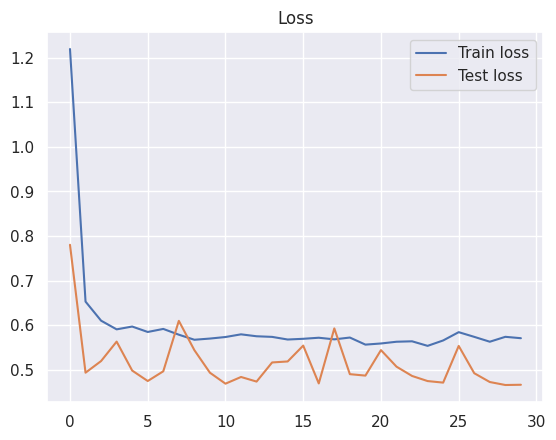

In [21]:
plt.plot( range(epochs),  train_losses)
plt.plot( range(epochs),  test_losses)
plt.legend(["Train loss", "Test loss"])
plt.title("Loss")